In [1]:
# !git clone 'https://github.com/Lorenz92/SKADC1.git'
# % cd SKADC1
# !echo $PWD

In [2]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import sys
from astropy.io import fits
import os
import statistics

import src.dataset as dataset
import src.datasetv2 as v2
import src.config as config
from src.utils import *
import src.preprocessing as prep
import src.models as models
import src.losses as loss

from keras import backend as K

path = config.TRAIN_PATCHES_FOLDER
%load_ext autoreload
%autoreload 2

np.random.seed(config.RANDOM_SEED)

In [3]:
for download_info in config.required_files:
    if not os.path.exists(os.path.join(config.TRAIN_DATA_FOLDER, download_info['file_name'])):
        download_data(download_info['file_name'], download_info['url'], config.DOWNLOAD_FOLDER)

In [4]:
# Dataset parsing and loading
# use "subset" to load a small portion of data for development/debugging purposes
# ska_dataset_cleanedByClaran = dataset.SKADataset(train_set_path=config.TRAIN_SET_PATH_CLEANED, subset=config.DATA_SUBSET)

# ska_dataset = dataset.SKADataset(train_set_path=config.TRAIN_SET_PATH, subset=config.DATA_SUBSET)
ska_dataset = dataset.SKADataset(train_set_path=config.TRAIN_SET_PATH_CLEANED, subset=config.DATA_SUBSET)

# print(ska_dataset_cleanedByClaran.raw_train_df.shape)
print(ska_dataset.raw_train_df.shape)
ska_dataset.raw_train_df.head()

(19222, 15)


,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,SIZE,CLASS,SELECTION,x,y
0,24121695,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,1,1,1,19704.519,17712.942
1,20167150,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,1,1,1,18401.338,17160.919
2,20045120,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,1,1,1,16493.600,18506.577
3,33938384,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,2,1,1,18020.319,18182.095
4,7527248,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,1,1,1,18125.824,18600.680


In [5]:
data_560Mhz_1000h_fits = fits.open('./data/training/560Mhz_1000h.fits')
# pb_560Mhz_1000h_fits = fits.open('./data/training/PrimaryBeam_B1.fits')
# data_560Mhz_1000h_fits.info()
data_560Mhz_1000h_fits.filename()

# print(data_560Mhz_1000h_fits[0].data)
# print(data_560Mhz_1000h_fits[0].data.shape)

data_560Mhz_1000h = data_560Mhz_1000h_fits[0].data[0,0]


### Preprocessing

In [6]:
ska_dataset.convert_boxes_to_px_coord(ska_dataset.raw_train_df, data_560Mhz_1000h_fits)
#coords = ska_dataset._convert_boxes_to_px_coord(ska_dataset.raw_train_df, data_560Mhz_1000h_fits[0].header )

100%|██████████| 19222/19222 [00:02<00:00, 7041.17it/s]
(19222, 15)
15
9
(19207, 15)
15
0
Enlarging bboxes...
DONE - Enlarging bboxes...


In [7]:
df_train = ska_dataset.cleaned_train_df
df_train.head()

,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,...,y,x1,y1,x2,y2,major_semia_px,minor_semia_px,pa_in_rad,width,height
0,24121695.0,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,...,17712.942,19699.889820,17708.334874,19709.135520,17717.543623,4.633850,4.593304,5.734349,9.245699,9.208748
1,20167150.0,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,...,17160.919,18314.128617,17121.775102,18488.540079,17200.059688,88.630651,35.798972,3.338082,174.411463,78.284586
2,20045120.0,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,...,18506.577,16490.663037,18502.418816,16496.536575,18510.726749,4.167982,2.916843,4.827354,5.873538,8.307933
3,33938384.0,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,...,18182.095,18018.267603,18181.289542,18022.370397,18182.900458,0.700870,0.220108,6.050027,4.102794,1.610916
4,7527248.0,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,...,18600.680,18124.509296,18597.936034,18127.132703,18603.414392,2.766243,1.253622,4.869573,2.623407,5.478358


In [8]:
df_train[['width', 'height']].describe()

,width,height
count,19207.000000,19207.000000
mean,4.075587,4.093373
std,3.459175,3.359250
min,0.009930,0.009930
25%,2.316125,2.356320
50%,3.475087,3.470834
75%,4.761761,4.780523
max,174.411463,92.846556


In [9]:
x1_min = int(np.floor(min(df_train['x1'])))
y1_min = int(np.floor(min(df_train['y1'])))

x2_max = int(np.floor(max(df_train['x2'])))
y2_max = int(np.floor(max(df_train['y2'])))

data_560Mhz_1000h_train = data_560Mhz_1000h[y1_min:y2_max, x1_min:x2_max]
data_560Mhz_1000h_train.shape


(3195, 3500)

(array([1.705e+03, 4.870e+02, 2.400e+02, 1.060e+02, 2.700e+01, 2.100e+01,
        1.500e+01, 8.000e+00, 6.000e+00, 2.000e+00, 5.000e+00, 5.000e+00,
        3.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 3.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([1.0000e-04, 2.4750e-04, 3.9500e-04, 5.4250e-04, 6.9000e-04,
        8.3750e-04, 9.8500e-04, 1.1325e-03, 1.2800e-03, 1.4275e-03,
        1.5750e-03, 1.7225e-03, 1.8700e-03, 2.0175e-03, 2.1650e-03,
        2.3125e-03, 2.4600e-03, 2.6075e-03, 2.7550e-03, 2.9025e-03,
        3.0500e-03, 3.1975e-03, 3.3450e-03, 3.4925e-03, 3.6400e-03,
        3.7875e-03, 3.9350e-03, 4.0825e-03, 4.2300e-03, 4.3775e-03,
        4.5250e-03, 4.6725e-03, 4.8200e-03, 4.9675e-03, 5.1150e-03,
        5.2625e-03, 5.4100

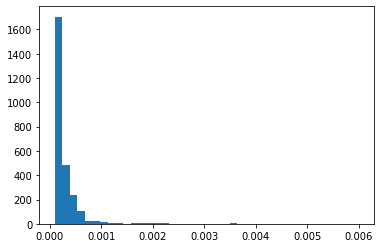

In [10]:
# histogram of noise (- noise, + noise)
# we know that negative values are due to noise, and we assume a gaussian noise distribution

data_flat = data_560Mhz_1000h_train.flatten()
min_val = min(data_flat)
plt.hist(data_flat, bins = 40, range = (0.0001, 0.006))#abs(min_val)))

In [11]:
# fits_max_data_560Mhz_1000h = np.max(data_560Mhz_1000h)
# print(fits_max_data_560Mhz_1000h)

# data_560Mhz_1000h_train_clipped = np.clip(data_560Mhz_1000h_train, a_min=0, a_max=fits_max_data_560Mhz_1000h)

# # NB the computation of the mean val must be after the noise removal
# data_flat = data_560Mhz_1000h_train_clipped.flatten()
# mean_GLval = statistics.mean(data_flat)
# max_GLval = max(data_flat)
# min_GLval = min(data_flat)
# print(mean_GLval)
# print(max_GLval)
# print(min_GLval)

In [12]:
data_560Mhz_1000h_train_clipped = np.clip(data_560Mhz_1000h_train, a_min=0, a_max=np.max(data_560Mhz_1000h))


  0%|          | 0/70 [00:00<?, ?it/s]image saved


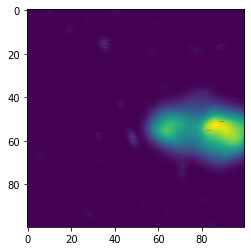


  1%|▏         | 1/70 [00:00<01:02,  1.10it/s]image saved


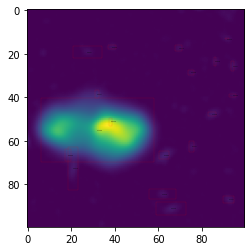


  3%|▎         | 2/70 [00:01<01:04,  1.05it/s]image saved


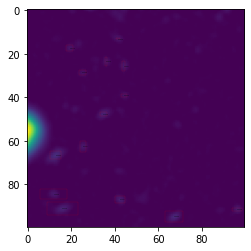


  4%|▍         | 3/70 [00:02<01:03,  1.06it/s]image saved


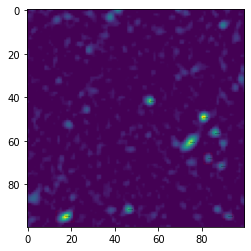


  6%|▌         | 4/70 [00:03<01:02,  1.05it/s]image saved


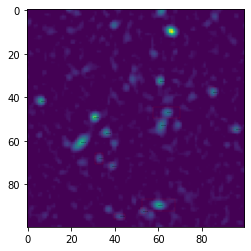


  7%|▋         | 5/70 [00:04<01:02,  1.05it/s]image saved


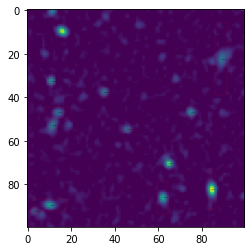


  9%|▊         | 6/70 [00:05<01:00,  1.06it/s]image saved


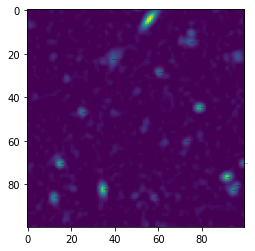


 10%|█         | 7/70 [00:06<01:01,  1.02it/s]image saved


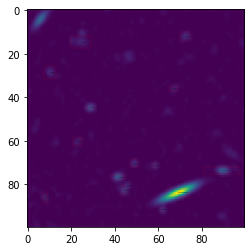


 11%|█▏        | 8/70 [00:07<01:02,  1.01s/it]image saved


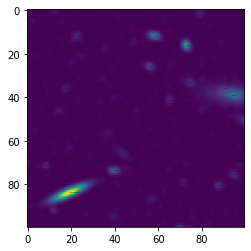


 13%|█▎        | 9/70 [00:08<01:02,  1.02s/it]image saved


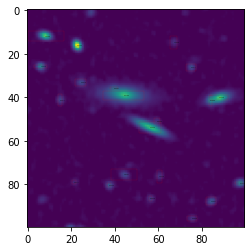


 14%|█▍        | 10/70 [00:09<01:02,  1.04s/it]image saved


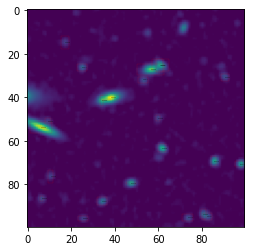


 16%|█▌        | 11/70 [00:11<01:02,  1.06s/it]image saved


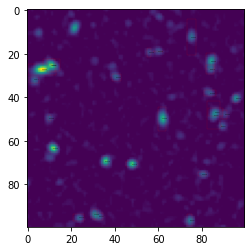


 17%|█▋        | 12/70 [00:12<01:03,  1.10s/it]image saved


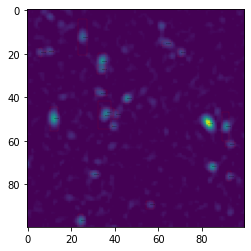


 19%|█▊        | 13/70 [00:13<01:03,  1.11s/it]image saved


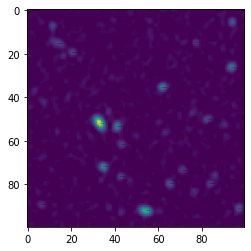


 20%|██        | 14/70 [00:14<01:00,  1.07s/it]image saved


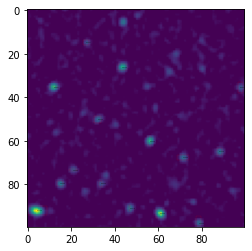


 21%|██▏       | 15/70 [00:15<00:57,  1.05s/it]image saved


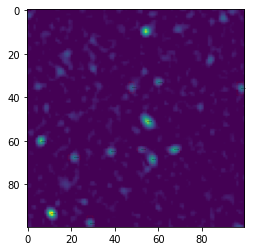


 23%|██▎       | 16/70 [00:16<00:54,  1.01s/it]image saved


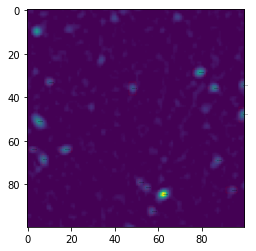


 24%|██▍       | 17/70 [00:17<00:53,  1.00s/it]image saved


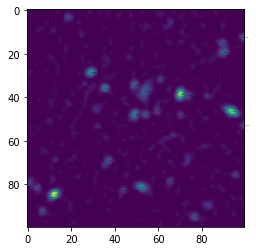


 26%|██▌       | 18/70 [00:18<00:55,  1.06s/it]image saved


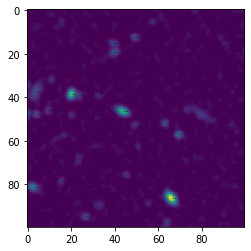


 27%|██▋       | 19/70 [00:19<00:59,  1.17s/it]image saved


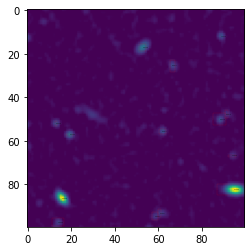


 29%|██▊       | 20/70 [00:20<00:57,  1.15s/it]image saved


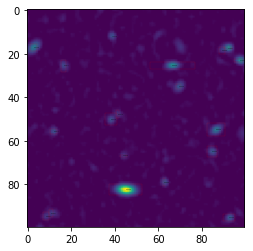


100%|██████████| 64/64 [00:22<00:00,  2.91it/s]


In [13]:
patch_list=[]
patch_list = ska_dataset.split_in_patch(data_560Mhz_1000h_train_clipped, df_train, data_560Mhz_1000h_fits.filename(), x1_min, y1_min, config.patch_dim, show_plot=True) # Remember to remove internal return

In [14]:
ska_dataset.proc_train_df[ska_dataset.proc_train_df['ID']==14777429]

,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,...,y1s,x2s,y2s,patch_name,patch_xo,patch_yo,patch_dim,bbox_w,bbox_h,class_label


In [15]:
# TODO: trasfromare in attributo della classe dataset
class_list = ska_dataset.proc_train_df['class_label'].unique()
print(class_list)

num_classes = len(ska_dataset.proc_train_df['class_label'].unique())
print(num_classes)

['1_1' '2_1' '3_1']
3


## Preprocessing - TODO:
- unire bbox sovrapposte?

In [16]:
#TODO: spostare in dataset dopo aver sistemato la classe dataset
from sklearn.model_selection import train_test_split

train_patch_list, val_patch_list = train_test_split(patch_list, test_size=.2, random_state=42)

In [17]:
print(len(train_patch_list))
print(len(val_patch_list))

16
5


In [18]:
# # Download VGG16 weights
# # 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
# if not os.path.exists(os.path.join(config.MODEL_WEIGHTS, 'vgg16')):
#     download_data('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 
#     'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', config.MODEL_WEIGHTS + '/vgg16')


In [19]:
# import keras
# from keras.layers import Input
# from src.layers import Expander, vgg16, RpnNet, RoiPoolingConv, Classifier
# import src.models as models
# import src.layers as layers

# backbone = 'vgg16'
# weight_path = os.path.join(f'./model/{backbone}/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

# input_shape_1=(config.resizeFinalDim, config.resizeFinalDim,1)
# input_shape_2=(None, 4)

# rpn_model, cls_model, total_model = models.get_model(input_shape_1=input_shape_1, input_shape_2=input_shape_2, anchor_num=config.anchor_num, pooling_regions=7, num_rois=4, num_classes=num_classes+1, weights=weight_path, backbone = 'vgg16')

# rpn_model.summary()
# cls_model.summary()
# total_model.summary()

In [20]:
# import tensorflow as tf
# from keras import backend as K


# lambda_rpn_regr = 1.0
# lambda_rpn_class = 1.0

# lambda_cls_regr = 1.0
# lambda_cls_class = 1.0

# epsilon = 1e-4

# def rpn_loss_regr(num_anchors):
#     """Loss function for rpn regression
#     Args:
#         num_anchors: number of anchors (9 in here)
#     Returns:
#         Smooth L1 loss function 
#                            0.5*x*x (if x_abs < 1)
#                            x_abx - 0.5 (otherwise)
#     """
#     def rpn_loss_regr_fixed_num(y_true, y_pred):

#         # x is the difference between true value and predicted value
#         x = y_true[:, :, :, 4 * num_anchors:] - y_pred

#         # absolute value of x
#         x_abs = K.abs(x)

#         # If x_abs <= 1.0, x_bool = 1
#         x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)

#         return lambda_rpn_regr * K.sum(
#             y_true[:, :, :, :4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :, :4 * num_anchors])

#     return rpn_loss_regr_fixed_num

# def rpn_loss_cls(num_anchors):
#     """Loss function for rpn classification
#     Args:
#         num_anchors: number of anchors (9 in here)
#         y_true[:, :, :, :9]: [0,1,0,0,0,0,0,1,0] means only the second and the eighth box is valid which contains pos or neg anchor => isValid
#         y_true[:, :, :, 9:]: [0,1,0,0,0,0,0,0,0] means the second box is pos and eighth box is negative
#     Returns:
#         lambda * sum((binary_crossentropy(isValid*y_pred,y_true))) / N
#     """
#     def rpn_loss_cls_fixed_num(y_true, y_pred):

#             return lambda_rpn_class * K.sum(y_true[:, :, :, :num_anchors] * K.binary_crossentropy(y_pred[:, :, :, :num_anchors], y_true[:, :, :, :num_anchors])) / K.sum(epsilon + y_true[:, :, :, :num_anchors])
            

#     return rpn_loss_cls_fixed_num

# def class_loss_regr(num_classes):
#     """Loss function for rpn regression
#     Args:
#         num_anchors: number of anchors (9 in here)
#     Returns:
#         Smooth L1 loss function 
#                            0.5*x*x (if x_abs < 1)
#                            x_abs - 0.5 (otherwise)
#     """
#     def class_loss_regr_fixed_num(y_true, y_pred):
#         x = y_true[:, :, 4*num_classes:] - y_pred # Here <y_true[:, :, 4*num_classes:]> is the y_class_regr_coords of Y2 in calc_iou, so it represents the roi coordinates
#         x_abs = K.abs(x)
#         x_bool = K.cast(K.less_equal(x_abs, 1.0), 'float32')
#         z = lambda_cls_regr * K.sum(y_true[:, :, :4*num_classes] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :4*num_classes]) # Here <y_true[:, :, :4*num_classes]> is the y_class_regr_label of Y2 in calc_iou, so it represents a mask for the roi to be considered
#         tf.print('z = ', z, output_stream=sys.stderr, sep=',')


#         return z
#     return class_loss_regr_fixed_num

# def class_loss_cls(y_true, y_pred):
#     return lambda_cls_class * K.mean(K.categorical_crossentropy(y_true[0, :, :], y_pred[0, :, :]))

In [21]:
# from keras.optimizers import Adam

# optimizer = Adam(lr=1e-5)
# optimizer_classifier = Adam(lr=1e-5)

# rpn_model.compile(optimizer=optimizer, loss=[rpn_loss_cls(config.anchor_num), rpn_loss_regr(config.anchor_num)])
# cls_model.compile(optimizer=optimizer_classifier, loss=[class_loss_cls, class_loss_regr(num_classes)], metrics=['accuracy'])
# total_model.compile(optimizer='sgd', loss='mae')

In [22]:
# total_model.save_weights('./test.h5')

In [23]:
# rpn_model.load_weights('./test.h5', by_name=True)

In [24]:
# # Check that all of the pretrained weights have been loaded.
# import numpy as np
# for i, j in zip(total_model.weights, rpn_model.weights):
#     # print(i)
#     # print(j)
#     assert np.allclose(i,j), 'Diversi!'

## datagen + calc_rpn -> rpn_net -> rpn_to_roi -> calc_iou -> cls_net

# Training

### Get FRCNN model

In [25]:
input_shape_1=(config.resizeFinalDim, config.resizeFinalDim,1)
input_shape_2=(None, 4)

backbone='vgg16'

rpn_model, detector_model, total_model = models.get_model(input_shape_1=input_shape_1, input_shape_2=input_shape_2, anchor_num=config.anchor_num, pooling_regions=7, num_rois=4, num_classes=len(class_list)+1, backbone=backbone)

rpn_model.summary()
detector_model.summary()
total_model.summary()

Model: "RegionProposal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600, 600, 1)]     0         
_________________________________________________________________
Custom_input_layer (Expander (None, 600, 600, 3)       6         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 600, 600, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 600, 600, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 300, 300, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 300, 300, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 300, 300, 128)  

### Load weights

In [32]:
models.load_weigths(rpn_model, detector_model, backbone, resume_train=False)
models.compile_models(rpn_model, detector_model, total_model, rpn_losses=[loss.rpn_loss_cls, loss.rpn_loss_regr], detector_losses=[loss.detector_loss_cls, loss.detector_loss_regr], class_list=class_list)

In [27]:
# Specifically checking backbone weights

# total_model.weights[24:25][0][0][0][0]

In [28]:
# Check that all of the pretrained weights have been loaded.
import numpy as np
for i, j in zip(total_model.weights, rpn_model.weights): 
    # print(i,j)
    assert np.allclose(i,j), 'Weights don\'t match!'

### Train

In [47]:
from src.train import *
train_frcnn(rpn_model, detector_model, total_model, train_patch_list, val_patch_list, class_list, config.TRAIN_PATCHES_FOLDER, backbone='vgg16', resume_train=True)

  0%|          | 0/4 [00:00<?, ?it/s]Epoch 0/1
250_16624_16729_100

100%|██████████| 4/4 [01:08<00:00, 17.04s/it]

100%|██████████| 12/12 [00:00<00:00, 5212.47it/s]Starting rpn model training on batch
pred = ,TensorShape([1, 37, 37, 12])
true = ,TensorShape([1, 37, 37, 24])

Best IoU found in this run: 0.5792506512429656
Starting detector model training on batch
X2 shape: (1, 102, 4)
1/1 [==============================] - 76s 76s/step - rpn_cls: 3.4080 - rpn_regr: 0.5279 - detector_cls: 0.7272 - detector_regr: 0.6430 - average number of objects: 2.0000
Mean number of bounding boxes from RPN overlapping ground truth boxes: 2.0
Classifier accuracy for bounding boxes from RPN: 0.5
Loss RPN classifier: 3.408029556274414
Loss RPN regression: 0.527860164642334
Loss Detector classifier: 0.7271772623062134
Loss Detector regression: 0.643038272857666
Elapsed time: 76.10330510139465
Total loss decreased from 7.22155886888504 to 5.306105256080627, saving weights
  0%|          | 0/4 [00:00<?, ?it

TODO - 20210508:
- troncamento rumore a 1e-6?

TODO - 20210605:
- modificare RPNNet in modo che dia in output anche la backbone - Lorenzo
- scrivere bene training loop: salvare le loss in un df su disco + salvare pesi modello ad ogni giro (Lorenzo - finire di debuggare)
- lanciare training

TODO - 20210620:
- implementare mAP ed inserirlo nel training ogni n epoche + plot mAP e magari plot precision vs recall
- implementare resNet50
- implementare plot predicted rois - Lorenzo
- implementare plot loss training - Lorenzo
- split dataset su combinazioni classi - Alice
- finire classe datasetv2 - Alice
- check se su colab le performance sono migliori - Lorenzo

In [39]:
r_epochs = 50


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), loss['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), loss['loss_rpn_reg'], 'r')
plt.title('loss_rpn_reg')
plt.subplot(2,2,1)
plt.plot(np.arange(0, r_epochs), loss['loss_cls_reg'], 'r')
plt.title('loss_cls_clsdd')
plt.subplot(2,2,2)
plt.plot(np.arange(0, r_epochs), loss['loss_cls_cls'], 'r')
plt.title('loss_cls_reg')
plt.show()

plt.plot(np.arange(0, r_epochs), loss['loss_rpn'], 'r')
plt.title('total_loss')
plt.show()

TypeError: list indices must be integers or slices, not str

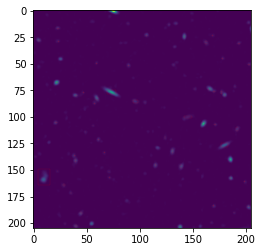

In [28]:
## DEBUG

patch = '1435_1781517815_205'
image_path = os.path.join(config.TRAIN_PATCHES_FOLDER, patch, f"{patch}.npy")
image_data_path = os.path.join(config.TRAIN_PATCHES_FOLDER, patch, f"{patch}.pkl")

p = np.load(image_path)
pdata = pd.read_pickle(image_data_path)

print_img(p, pdata)


In [ ]:
#TODO: Provare YOLO -> forse meglio le efficientNet
# Ablation study
# Provare, a parità di frequenza, le esposizioni diverse come canali

In [1]:
# from tensorflow.keras.applications import EfficientNetB0
# model = EfficientNetB0(weights='imagenet')